# A2 : Bias on Wikipedia
Objective :  Analyze what the nature of political articles on Wikipedia tell us about bias in Wikipedia's content.

Author : Niharika Sharma 

References : 
1. https://figshare.com/articles/Untitled_Item/5513449
2. https://wiki.communitydata.cc/HCDS_(Fall_2017)/Assignments#A2:_Bias_in_data
3. http://www.prb.org/DataFinder/Topic/Rankings.aspx?ind=14
4. https://www.mediawiki.org/wiki/ORES

### Import all the libraries

In [1]:
# import all the libraries - Set up 
import requests
import json
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### Making ORES requests
The function makes a request with multiple revision IDs.

In [2]:
headers = {'User-Agent' : 'https://github.com/niharikasharma', 'From' : 'njsharma@uw.edu'}

def get_ores_data(revision_ids, headers):
    
    # Define the endpoint
    endpoint = 'https://ores.wikimedia.org/v3/scores/{project}/?models={model}&revids={revids}'
    
    # Specify the parameters - smushing all the revision IDs together separated by | marks.
    # Yes, 'smush' is a technical term, trust me I'm a scientist.
    # What do you mean "but people trusting scientists regularly goes horribly wrong" who taught you tha- oh.  
    params = {'project' : 'enwiki',
              'model'   : 'wp10',
              'revids'  : '|'.join(str(x) for x in revision_ids)
              }
    api_call = requests.get(endpoint.format(**params))
    response = api_call.json()
    return json.dumps(response, indent=4, sort_keys=True)


### Getting article quality predictions
Importing the other data from page_data.csv and calling the get_ores_data function. We are appending 100 revision_ids and then calling the get_ores_data function in batch form.
ORES API returns the quality of an article and a series of probabilities for each of the quality. There are 6 article qualities as follows:
1. FA - Featured article
2. GA - Good article
3. B - B-class article
4. C - C-class article
5. Start - Start-class article
6. Stub - Stub-class article

In [3]:
i = 0
ids = []

revision_id = []
article_quality = []

with open('data/page_data.csv') as csvfile:
    # Skip first line (if any)
    next(csvfile, None)
    reader = csv.reader(csvfile)
    for row in reader:
        ids.append(row[2])
        i = i + 1
        if i == 100:
            # batch of 100 revision_ids
            i = 0
            # call the function
            result = get_ores_data(ids, headers)
            # load the result as JSON
            data = json.loads(result)
            for d in data['enwiki']['scores']:
                try:
                    article_quality.append(data['enwiki']['scores'][d]['wp10']['score']['prediction'])
                    revision_id.append(d)
                except KeyError:
                    print(data['enwiki']['scores'][d]['wp10']['error']['message'])
            ids = []
    if len(ids) != 0:
            result = get_ores_data(ids, headers)
            # load the result as JSON
            data = json.loads(result)
            for d in data['enwiki']['scores']:
                try:
                    article_quality.append(data['enwiki']['scores'][d]['wp10']['score']['prediction'])
                    revision_id.append(d)
                except KeyError:
                    print(data['enwiki']['scores'][d]['wp10']['error']['message'])

# Store the ORES data into dataframe
df_ores = pd.DataFrame(
    {'revision_id': revision_id,
     'article_quality': article_quality
    })

print(df_ores.shape)

RevisionNotFound: Could not find revision ({revision}:806811023)
RevisionNotFound: Could not find revision ({revision}:807367166)
RevisionNotFound: Could not find revision ({revision}:807367030)
RevisionNotFound: Could not find revision ({revision}:807484325)
(47193, 2)


### Combining the datasets
Merging the ORES API data, page_data.csv and Population Mid-2015.csv, and excluding ids with no prediction.

In [4]:
# page data
df_page = pd.read_csv('data/page_data.csv', names=['page', 'country', 'rev_id'])
# Join the tables using left join as we want to exclude the revision ids with no prediction 
df_wikipedia = pd.merge(df_ores, df_page, how = 'left', left_on = 'revision_id', right_on = 'rev_id')

# merge wikipedia and population data
df_pop = pd.read_csv('data/Population Mid-2015.csv', skiprows=[0, 1, 2], names=['Location','Location Type','TimeFrame','Data Type','Data','Footnotes'])

# inner join so that we can remove the rows that do not have matching data
df_final = pd.merge(df_wikipedia, df_pop, how = 'inner', left_on = 'country', right_on = 'Location')

# delete unwanted columns
columns = ['Location Type','TimeFrame','Data Type','Footnotes', 'rev_id', 'Location']
df_final = df_final.drop(columns, axis=1)

# rename columns
df_final = df_final.rename(columns={'page': 'article_name', 'Data': 'population'})
print(df_final.columns)
print(df_final.shape)

Index(['article_quality', 'revision_id', 'article_name', 'country',
       'population'],
      dtype='object')
(45795, 5)


### Consolidate the remaining data into a single CSV file

Finally, saving the dataframe in final-data.csv. The headers of the file are as follows:

#### Column  
country  
article_name  
revision_id  
article_quality  
population

In [5]:
# convert population to int
df_final["population"] = df_final["population"].apply(lambda x: int(x.replace(',', '')))
print(df_final["population"].head())
# save the final dataframe into csv
df_final.to_csv('data/final-data.csv', sep=',', encoding='utf-8', index=False)

0    11211064
1    11211064
2    11211064
3    11211064
4    11211064
Name: population, dtype: int64


### Analysis
Calculating the proportion (as a percentage) of articles-per-population articles for each country.

In [6]:
# articles-per-population for each country data
df = pd.read_csv('data/final-data.csv')


grouped = df.groupby(['country'])
df_articles_per_population = grouped.agg({'revision_id' : 'count', 'population' : np.mean}).reset_index()
df_articles_per_population['percent'] = 100.00*df_articles_per_population['revision_id']/df_articles_per_population['population']
print(df_articles_per_population.head())

       country  revision_id  population   percent
0  Afghanistan          327    32247000  0.001014
1      Albania          460     2892000  0.015906
2      Algeria          119    39948000  0.000298
3      Andorra           34       78000  0.043590
4       Angola          110    25000000  0.000440


### Analysis
Calculating the proportion (as a percentage) of high-quality articles for each country.

In [7]:
# High-quality articles for each country

df_high_quality = df.groupby(['country', 'article_quality']).agg({'revision_id' : 'count'})
# quality percentage per category
df_high_quality['percent'] = df_high_quality.groupby(level=0).apply(lambda x: 100.0 * x / x.sum())
df_high_quality = df_high_quality.reset_index()
# remove data other than FA and GA
df_high_quality = df_high_quality[(df_high_quality["article_quality"] == 'FA') | (df_high_quality["article_quality"] == 'GA')]
df_high_quality = df_high_quality.groupby(['country']).agg({'percent' : 'sum'}).reset_index()
print(df_high_quality.head())

       country   percent
0  Afghanistan  4.587156
1      Albania  1.086957
2      Algeria  1.680672
3       Angola  0.909091
4    Argentina  3.427419


### Tables and Visualizations 
#### 10 highest-ranked countries in terms of number of politician articles as a proportion of country population

   index                         country  revision_id  population   percent
0    120                           Nauru           53       10860  0.488029
1    173                          Tuvalu           55       11800  0.466102
2    141                      San Marino           82       33000  0.248485
3    113                          Monaco           40       38088  0.105020
4     97                   Liechtenstein           29       37570  0.077189
5    107                Marshall Islands           37       55000  0.067273
6     72                         Iceland          206      330828  0.062268
7    168                           Tonga           63      103300  0.060987
8      3                         Andorra           34       78000  0.043590
9     54  Federated States of Micronesia           38      103000  0.036893


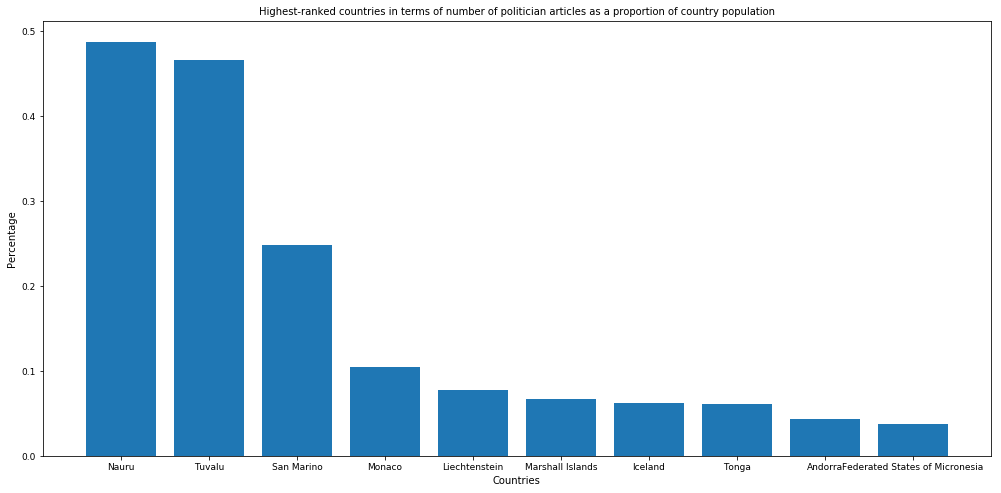

In [8]:
# 10 highest-ranked countries in terms of number of politician articles as a proportion of country population
viz1 = df_articles_per_population.sort_values(by=['percent'], ascending=[0]).head(10).reset_index()
print(viz1)
fig = plt.figure(figsize=(17,8))
plt.xticks(fontsize=9)  
plt.yticks(fontsize=9) 
ax = fig.add_subplot(111)
ax.bar(viz1.index, viz1.percent, width=0.8)
ax.set_xticks(viz1.index)
ax.set_xticklabels(viz1.country)
ax.set_xlabel("Countries", fontsize=10)
ax.set_ylabel("Percentage", fontsize=10)
ax.set_title("Highest-ranked countries in terms of number of politician articles as a proportion of country population", fontsize=10)
plt.show()
# Generate a .png formatted image of the final graph
fig.savefig('highest_ranked_countries_number_of_politians_per_article.png')

#### 10 lowest-ranked countries in terms of number of politician articles as a proportion of country population

   index              country  revision_id  population   percent
0     73                India          989  1314097616  0.000075
1     34                China         1138  1371920000  0.000083
2     74            Indonesia          215   255741973  0.000084
3    180           Uzbekistan           29    31290791  0.000093
4     53             Ethiopia          105    98148000  0.000107
5     86         Korea, North           39    24983000  0.000156
6    185               Zambia           26    15473900  0.000168
7    166             Thailand          112    65121250  0.000172
8     38  Congo, Dem. Rep. of          142    73340200  0.000194
9     13           Bangladesh          324   160411000  0.000202


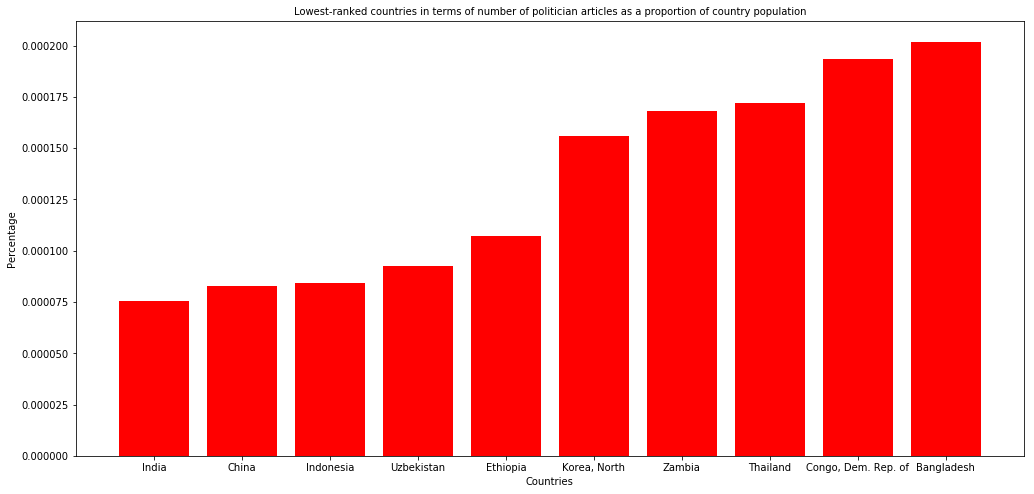

In [9]:
# 10 lowest-ranked countries in terms of number of politician articles as a proportion of country population
viz2 = df_articles_per_population.sort_values(by=['percent'], ascending=[1]).head(10).reset_index()
print(viz2)
fig = plt.figure(figsize=(17,8))
plt.xticks(fontsize=10)  
plt.yticks(fontsize=10) 
ax = fig.add_subplot(111)
ax.bar(viz2.index, viz2.percent, width=0.8, color = 'r')
ax.set_xticks(viz2.index)
ax.set_xticklabels(viz2.country)
ax.set_xlabel("Countries", fontsize=10)
ax.set_ylabel("Percentage", fontsize=10)
ax.set_title("Lowest-ranked countries in terms of number of politician articles as a proportion of country population", fontsize=10)
plt.show()
# Generate a .png formatted image of the final graph
fig.savefig('lowest_ranked_countries_number_of_politians_per_article.png')

#### 10 highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country

   index                   country    percent
0     68              Korea, North  23.076923
1    113              Saudi Arabia  11.764706
2    142                Uzbekistan  10.344828
3     23  Central African Republic  10.294118
4    110                   Romania   9.770115
5     52             Guinea-Bissau   9.523810
6     12                    Bhutan   9.090909
7    145                   Vietnam   8.376963
8     35                  Dominica   8.333333
9     86                Mauritania   7.692308


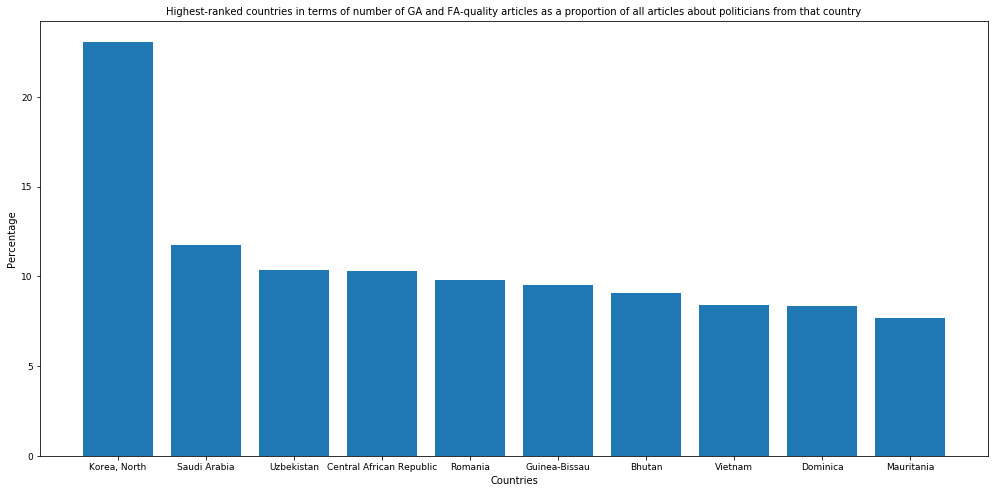

In [10]:
# highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country
viz3 = df_high_quality.sort_values(by=['percent'], ascending=[0]).head(10).reset_index()
print(viz3)
fig = plt.figure(figsize=(17,8))
plt.xticks(fontsize=9)  
plt.yticks(fontsize=9) 
ax = fig.add_subplot(111)
ax.bar(viz3.index, viz3.percent, width=0.8)
ax.set_xticks(viz3.index)
ax.set_xticklabels(viz3.country)
ax.set_xlabel("Countries", fontsize=10)
ax.set_ylabel("Percentage", fontsize=10)
ax.set_title("Highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country", fontsize=10)
plt.show()
# Generate a .png formatted image of the final graph
fig.savefig('highest_ranked_countries_aritcle_qualitywise.png')

#### 10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country

   index         country   percent
0    129        Tanzania  0.245098
1     33  Czech Republic  0.393701
2     78       Lithuania  0.403226
3     91         Morocco  0.480769
4     42            Fiji  0.502513
5    136          Uganda  0.531915
6     13         Bolivia  0.534759
7     79      Luxembourg  0.555556
8    105            Peru  0.564972
9    116    Sierra Leone  0.602410


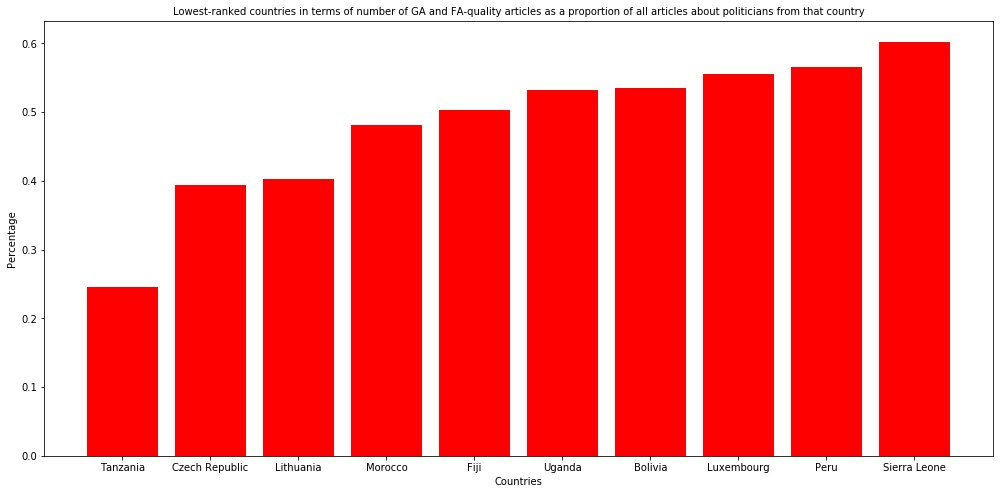

In [11]:
# lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country
viz4 = df_high_quality.sort_values(by=['percent'], ascending=[1]).head(10).reset_index()
print(viz4)
fig = plt.figure(figsize=(17,8))
plt.xticks(fontsize=10)  
plt.yticks(fontsize=10) 
ax = fig.add_subplot(111)
ax.bar(viz4.index, viz4.percent, width=0.8, color = 'r')
ax.set_xticks(viz4.index)
ax.set_xticklabels(viz4.country)
ax.set_xlabel("Countries", fontsize=10)
ax.set_ylabel("Percentage", fontsize=10)
ax.set_title("Lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country", fontsize=10)
plt.show()
fig.savefig('lowestest_ranked_countries_aritcle_qualitywise.png')